In [1]:
%load_ext autoreload

In [19]:
%autoreload

from functools import partial
from typing import Any, Mapping, Sequence

import distrax
import haiku as hk
import jax
import jax.numpy as jnp
import jax.scipy.special as special
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import optax
from jax import random

Array = jnp.ndarray
PRNGKey = Array
Batch = Mapping[str, np.ndarray]
OptState = Any

In [3]:
def diag_gaussian_sample(rng, mean, log_std):
    # Take a single sample from a diagonal multivariate Gaussian.
    return mean + jnp.exp(log_std) * random.normal(rng, mean.shape)


def diag_gaussian_logpdf(x, mean, log_std):
    # Evaluate a single point on a diagonal multivariate Gaussian.
    return jnp.sum(jax.vmap(stats.norm.logpdf)(x, mean, jnp.exp(log_std)))


def elbo(logprob, rng, mean, log_std):
    # Single-sample Monte Carlo estimate of the variational lower bound.
    sample = diag_gaussian_sample(rng, mean, log_std)
    return logprob(sample) - diag_gaussian_logpdf(sample, mean, log_std)


def batch_elbo(logprob, rng, params, num_samples):
    # Average over a batch of random samples.
    rngs = random.split(rng, num_samples)
    vectorized_elbo = jax.vmap(partial(elbo, logprob), in_axes=(0, None, None))
    return jnp.mean(vectorized_elbo(rngs, *params))

In [149]:
def make_conditioner(
    event_shape: Sequence[int], hidden_sizes: Sequence[int], num_bijector_params: int
) -> hk.Sequential:
    """Creates an MLP conditioner for each layer of the flow."""
    return hk.Sequential(
        [
            hk.Flatten(preserve_dims=-len(event_shape)),
            hk.nets.MLP(hidden_sizes, activate_final=True),
            # We initialize this linear layer to zero so that the flow is initialized
            # to the identity function.
            hk.Linear(
                np.prod(event_shape) * num_bijector_params,
                w_init=jnp.zeros,
                b_init=jnp.zeros,
            ),
            hk.Reshape(tuple(event_shape) + (num_bijector_params,), preserve_dims=-1),
        ]
    )

In [181]:
def make_flow_model(
    event_shape: Sequence[int],
    num_layers: int,
    hidden_sizes: Sequence[int],
    num_bins: int,
) -> distrax.Transformed:
    """Creates the flow model."""
    # Alternating binary mask.
    mask = jnp.arange(0, np.prod(event_shape)) % 2
    mask = jnp.reshape(mask, event_shape)
    mask = mask.astype(bool)

    def bijector_fn(params: Array):
        return distrax.RationalQuadraticSpline(params, range_min=0.0, range_max=1.0)

    # Number of parameters for the rational-quadratic spline:
    # - `num_bins` bin widths
    # - `num_bins` bin heights
    # - `num_bins + 1` knot slopes
    # for a total of `3 * num_bins + 1` parameters.
    num_bijector_params = 3 * num_bins + 1

    layers = []
    for _ in range(num_layers):
        layer = distrax.MaskedCoupling(
            mask=mask,
            bijector=bijector_fn,
            conditioner=make_conditioner(
                event_shape, hidden_sizes, num_bijector_params
            ),
        )
        layers.append(layer)
        # Flip the mask after each layer.
        mask = jnp.logical_not(mask)

    # We invert the flow so that the `forward` method is called with `log_prob`.
    flow = distrax.Inverse(distrax.Chain(layers))
    base_distribution = distrax.Independent(
        distrax.MultivariateNormalFullCovariance(
            loc=jnp.zeros(np.prod(event_shape)),
            covariance_matrix=jnp.eye(np.prod(event_shape)),
        )
    )

    return distrax.Transformed(base_distribution, flow)


@hk.without_apply_rng
@hk.transform
def model(
    event_shape: Sequence[int],
    num_layers: int,
    hidden_sizes: Sequence[int],
    num_bins: int,
    data,
):
    m = make_flow_model(
        event_shape=event_shape,
        num_layers=num_layers,
        hidden_sizes=hidden_sizes,
        num_bins=num_bins,
    )
    return m.log_prob(data)

In [15]:
def dual_moon_logpdf(x, params):
    term1 = 0.5 * ((jnp.linalg.norm(x, axis=-1) - 2) / 0.4) ** 2
    term2 = -0.5 * ((x[..., :1] + jnp.array([-2.0, 2.0])) / 0.6) ** 2
    pe = term1 - special.logsumexp(term2, axis=-1)
    return -pe

In [16]:
@partial(jax.jit, static_argnums=(0, 1, 2, 4))
def mesh_eval(func, x_limits, y_limits, params, num_ticks=101):
    # Evaluate func on a 2D grid defined by x_limits and y_limits.
    x = np.linspace(*x_limits, num=num_ticks)
    y = np.linspace(*y_limits, num=num_ticks)
    X, Y = np.meshgrid(x, y)
    xy_vec = np.stack([X.ravel(), Y.ravel()]).T
    zs = jax.vmap(func, in_axes=(0, None))(xy_vec, params)
    return X, Y, zs.reshape(X.shape)

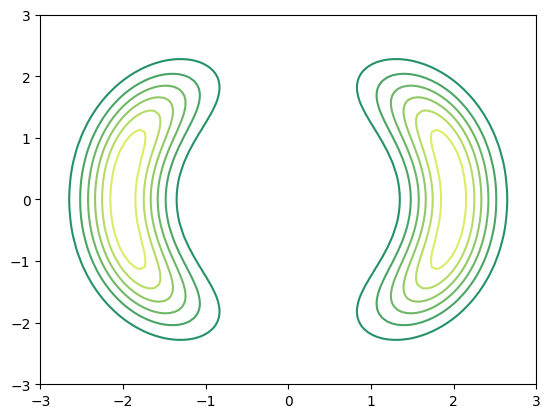

In [31]:
x, y, z = mesh_eval(dual_moon_logpdf, (-3, 3), (-3, 3), None)
plt.contour(x, y, jnp.exp(z), cmap="summer")

In [79]:
D = (2,)
num_layers = 8
hidden_sizes = [500] * 2
num_bins = 4
key = random.PRNGKey(0)

In [174]:
x = jax.vmap(diag_gaussian_sample, in_axes=(0, None, None))(
    jax.random.split(key, 10), jnp.zeros(2), jnp.zeros(2)
)

In [182]:
params = model.init(key, D, num_layers, hidden_sizes, num_bins, x)

In [183]:
apply = model.apply(params, D, num_layers, hidden_sizes, num_bins, x)

In [178]:
apply

DeviceArray([-inf, -inf, -inf,   0., -inf, -inf, -inf, -inf, -inf, -inf],            dtype=float32)

In [144]:
flow_init, flow_apply = hk.transform(make_flow_model)
params = flow_init()
apply =

TypeError: 'Transformed' object is not callable

In [141]:
apply.log_prob()

ValueError: All `hk.Module`s must be initialized inside an `hk.transform`.

In [80]:
model = make_flow_model(D, num_layers, hidden_sizes, num_bins)